In [1]:
%load_ext autoreload
%autoreload 

In [2]:
from vssutils import VssFileClient, VssDBClient, MovieSegment, RailSegmentView, VssVideoReader, FrameImage, VssClient, LocalSecrets, CameraSegment
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import os
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.keyvault.secrets import SecretClient

In [3]:
secrets = LocalSecrets('BH-VSService-Test-KV', InteractiveBrowserCredential())
vss_client = VssClient('test', secrets)
# vss_file_client = vss_client.eurailscout_vss_file_client
vss_file_client = vss_client.asset_insight_vss_file_client

In [4]:
query = """SELECT * from movie
                LEFT JOIN delivery on movie.delivery_id = delivery.id
                WHERE pgo_gebied = 'amstelsepoort'

                """

with vss_client.getDbClient() as sut:
    query_result = sut.query(query)

In [5]:
query_result

,id,storage_file_path,delivery_id,camera,recording_date,status,global_reference_index,id,run_id,delivery_date_time,supplier,pgo_gebied,spoortak_model_version
0,2,vsb_amstelsepoort_psh/2022/03/29/2022_3_8_12_5...,2,Rail Left Inside,2022-03-08,Processed,464523.0,2,2022_10,2022-03-07,asset-insight,amstelsepoort,18
1,4,vsb_amstelsepoort_psh/2021/09/15/2021_8_25_13_...,4,Rail Left Inside,2021-08-25,Processed,340358.0,4,2021_34,2021-08-23,asset-insight,amstelsepoort,17
2,16,vsb_amstelsepoort_psh/2022/08/26/2022_8_24_13_...,15,Rail Right Outside,2022-08-24,Processed,290627.0,15,2022_34,2022-08-22,asset-insight,amstelsepoort,18
3,36,vsb_amstelsepoort_psh/2021/03/18/2021_3_9_15_2...,32,Rail Right Outside,2021-03-09,Processed,708048.0,32,2021_10,2021-03-08,asset-insight,amstelsepoort,16
4,45,vsb_amstelsepoort_psh/2022/08/26/2022_8_24_13_...,15,Ballast Right,2022-08-24,Processed,NaN,15,2022_34,2022-08-22,asset-insight,amstelsepoort,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11227,108420,vsb_amstelsepoort_psh/2019/10/16/avi/7/Camera7...,52,Rail Right Outside,2019-10-16,Processed,162104.0,52,2019_41,2019-10-14,asset-insight,amstelsepoort,13
11228,108446,vsb_amstelsepoort_psh/2022/03/29/2022_3_9_14_4...,2,Train Back,2022-03-09,Processed,98225.0,2,2022_10,2022-03-07,asset-insight,amstelsepoort,18
11229,108447,vsb_amstelsepoort_psh/2019/10/15/avi/2/Camera2...,52,Rail Right Top,2019-10-15,Processed,423674.0,52,2019_41,2019-10-14,asset-insight,amstelsepoort,13
11230,108452,vsb_amstelsepoort_psh/2022/03/29/2022_3_9_14_4...,2,Train Front,2022-03-09,Processed,188649.0,2,2022_10,2022-03-07,asset-insight,amstelsepoort,18


In [6]:
# query = """SELECT kilometrage, frame_km_direction, x, y, side, camera, frame_index, storage_file_path,
#                  run_id, switch_leg_identifier.switch_name, geocode, spoortak_segment.id as segment_id, supplier
#             FROM frame
#             LEFT JOIN spoortak_segment on frame.spoortak_segment_id=spoortak_segment.id
#             LEFT JOIN spoortak_identifier on spoortak_segment.spoortak_id=spoortak_identifier.id
#             LEFT JOIN switch_leg_identifier on spoortak_segment.switch_leg_id=switch_leg_identifier.id
#             LEFT JOIN movie on spoortak_segment.movie_id = movie.id
#             LEFT JOIN track_side on spoortak_segment.track_side_id = track_side.id
#             LEFT JOIN delivery on movie.delivery_id = delivery.id
#                 WHERE switch_leg_identifier.switch_name = '1183'
#                 AND geocode = 587
#                 AND run_id = '2022_10'
#                 AND camera = 'Rail Right Top'
#
#                 """
query = """SELECT kilometrage, frame_km_direction, x, y, side, camera, frame_index, storage_file_path,
                 run_id, switch_leg_identifier.switch_name, geocode, spoortak_segment.id as segment_id, supplier
            FROM frame
            LEFT JOIN spoortak_segment on frame.spoortak_segment_id=spoortak_segment.id
            LEFT JOIN spoortak_identifier on spoortak_segment.spoortak_id=spoortak_identifier.id
            LEFT JOIN switch_leg_identifier on spoortak_segment.switch_leg_id=switch_leg_identifier.id
            LEFT JOIN movie on spoortak_segment.movie_id = movie.id
            LEFT JOIN track_side on spoortak_segment.track_side_id = track_side.id
            LEFT JOIN delivery on movie.delivery_id = delivery.id
                WHERE switch_leg_identifier.switch_name = '504'
                AND geocode = 542
                AND run_id = '2022_31'
                AND camera = 'Rail Left Top'
                """

#4028 and 4433
# query database
with vss_client.getDbClient() as sut:
    # query_result = sut.query_spoor_data('097_3609R_22.0', 21.37401, 21.39994, True)
    query_result = sut.query(query)

In [7]:
query_result

,kilometrage,frame_km_direction,x,y,side,camera,frame_index,storage_file_path,run_id,switch_name,geocode,segment_id,supplier
0,29.58772,1,105241.983,424527.650,Right,Rail Left Top,496,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
1,29.58797,1,105241.750,424527.739,Right,Rail Left Top,497,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
2,29.58821,1,105241.520,424527.826,Right,Rail Left Top,498,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
3,29.58846,1,105241.288,424527.915,Right,Rail Left Top,499,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
4,29.58870,1,105241.059,424528.002,Right,Rail Left Top,500,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,29.62012,1,105210.306,424538.335,Right,Rail Left Top,880,vsb_zeezevenaar_psh/2022/08/12/2022_8_7_4_39_1...,2022_31,504,542,2466865,asset-insight
418,29.62036,1,105210.068,424538.398,Right,Rail Left Top,881,vsb_zeezevenaar_psh/2022/08/12/2022_8_7_4_39_1...,2022_31,504,542,2466865,asset-insight
419,29.62061,1,105209.830,424538.462,Right,Rail Left Top,882,vsb_zeezevenaar_psh/2022/08/12/2022_8_7_4_39_1...,2022_31,504,542,2466865,asset-insight
420,29.62086,1,105209.592,424538.526,Right,Rail Left Top,883,vsb_zeezevenaar_psh/2022/08/12/2022_8_7_4_39_1...,2022_31,504,542,2466865,asset-insight


In [8]:
# see overv|iew of meta data - frames per movie
query_result.groupby(by=['storage_file_path', 'segment_id']).count()

,,kilometrage,frame_km_direction,x,y,side,camera,frame_index,run_id,switch_name,geocode,supplier
storage_file_path,segment_id,,,,,,,,,,,
vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_13/avi/3/Camera3_0.avi,1368845,140,140,140,140,140,140,140,140,140,140,140
vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_13/avi/3/Camera3_7.avi,136837,141,141,141,141,141,141,141,141,141,141,141
vsb_zeezevenaar_psh/2022/08/12/2022_8_7_4_39_10/avi/3/Camera3_0.avi,2466865,141,141,141,141,141,141,141,141,141,141,141


In [9]:
# filter on delivery 2020_12
meta_data = query_result[query_result['segment_id'] == 1368845]
# meta_data = query_result[query_result['segment_id'] == 80432]

# filter on movies with more than one frame
# meta_data = meta_data.groupby(by='storage_file_path').filter(lambda x: len(x) > 1)
# meta_data.groupby(by='storage_file_path').count()

In [10]:
meta_data

,kilometrage,frame_km_direction,x,y,side,camera,frame_index,storage_file_path,run_id,switch_name,geocode,segment_id,supplier
0,29.58772,1,105241.983,424527.650,Right,Rail Left Top,496,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
1,29.58797,1,105241.750,424527.739,Right,Rail Left Top,497,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
2,29.58821,1,105241.520,424527.826,Right,Rail Left Top,498,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
3,29.58846,1,105241.288,424527.915,Right,Rail Left Top,499,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
4,29.58870,1,105241.059,424528.002,Right,Rail Left Top,500,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,29.62002,1,105210.398,424538.310,Right,Rail Left Top,631,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
136,29.62027,1,105210.159,424538.374,Right,Rail Left Top,632,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
137,29.62052,1,105209.920,424538.438,Right,Rail Left Top,633,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight
138,29.62077,1,105209.680,424538.503,Right,Rail Left Top,634,vsb_zeezevenaar_psh/2022/08/12/2022_8_6_4_56_1...,2022_31,504,542,1368845,asset-insight


In [11]:
# create RailSegmentView object from list of MovieSegment objects 
# segment_movies = RailSegmentView([MovieSegment(meta_df) for _, meta_df in meta_data.groupby(by=['segment_id','storage_file_path'])])

camera = CameraSegment(meta_data)
camera.retrieve_frames(vss_file_client)
# segment_movies.retrieve_frames(vss_client.assetinsight_vss_file_client)
camera.movie_segments[0].frames
# camera.movie_segments[0].annotate_frames('frame_index')

# if not os.path.exists('local_data'):
#     os.makedirs('local_data')
# cv2.imwrite('local_data/test_concat_balast_v2.png', segment_movies.concat_ballast())

In [12]:
# Concat frames
image = FrameImage.convert_bgr_to_rgb(camera.concat_frames())


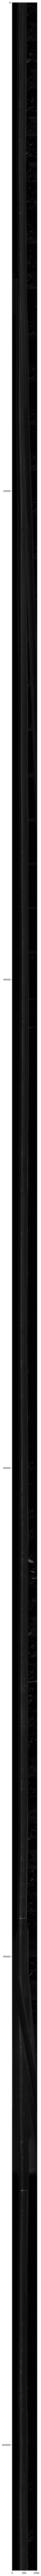

In [13]:
# show plot with matplotlib, change colors to rgb (opencv has bgr default)
plt.figure(figsize=(200,200))
plt.imshow(image)


In [14]:
plt.imsave("2343_1_4.png", image)
